<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!ls /content/drive/MyDrive/faces_dataset_small 

ls: cannot access '/content/drive/MyDrive/faces_dataset_small': No such file or directory


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

  dataset = ImageFolder(root="/content/drive/MyDrive/1", transform=transform)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return dataloader
  pass

def get_data(image_size, batch_size):
  transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

  dataset = ImageFolder(root="/content/drive/MyDrive/2", transform=transform)

  return dataset
  pass

In [ ]:
image_size = 64

#TODO: build dataloader and transfer it to device
batch_size = 64

dataloader = get_dataloader(image_size, batch_size)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

def denorm(img_tensors):
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    return img_tensors * stats[1][0] + stats[0][0]

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

(-0.5, 63.5, 63.5, -0.5)

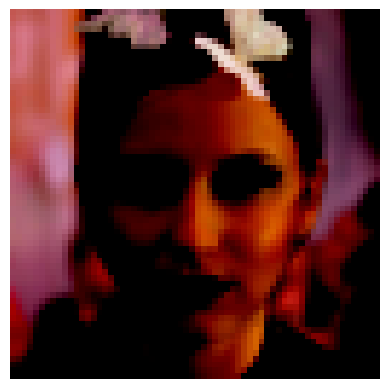

In [ ]:
test_img = next(iter(dataloader))[0][0]
plt.imshow(test_img.permute(1,2,0))
plt.axis('off')

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
latent_size = 128 # choose latent size

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
                nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False), # in: latent_size x 1 x 1
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True), # out: 512 x 4 x 4
                
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True), # out: 256 x 8 x 8
                
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True), # out: 128 x 16 x 16
                
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True), # out: 64 x 32 x 32
                
                nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()) # out: 3 x 64 x 64
        
    def forward(self, x):
        x = self.gen(x)
        return x

In [ ]:
generator = Generator().to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discr = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # in: 3 x 64 x 64
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True), # out: 64 x 32 x 32

                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True), # out: 128 x 16 x 16

                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True), # out: 256 x 8 x 8

                nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True), # out: 512 x 4 x 4
                
                nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), 
                nn.Flatten(),
                nn.Sigmoid()) # out: 1 x 1 x 1

    def forward(self, x):
        x = self.discr(x)
        return x

In [ ]:
discriminator = Discriminator().to(device)

In [ ]:
latent_size = 128 # choose latent size

noise = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(noise)

In [ ]:
import torch.nn.functional as F

def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
import torch.optim as optim

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    generator.train()
    discriminator.train()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    lowest_loss_g = np.inf
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(device)
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        if losses_g[-1] < lowest_loss_g:
            print(f'Generator score increase from {lowest_loss_g} to {losses_g[-1]}. Saving weights')
            lowest_loss_g = losses_g[-1]
            torch.save(generator.state_dict(), 'gen_best_weights.pth')
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_score

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
epochs = 40

generator.apply(weights_init)

path_weights = None

if path_weights is None:
    history = fit(epochs, lr)
    # Save the model checkpoints 
    torch.save(generator.state_dict(), 'gen_last_weight.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')
    losses_g, losses_d, real_scores, fake_scores = history

else:
    generator = Generator()
    generator.load_state_dict(torch.load('../input/generator-weights-2/generator.pth', map_location=torch.device('cpu')))

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

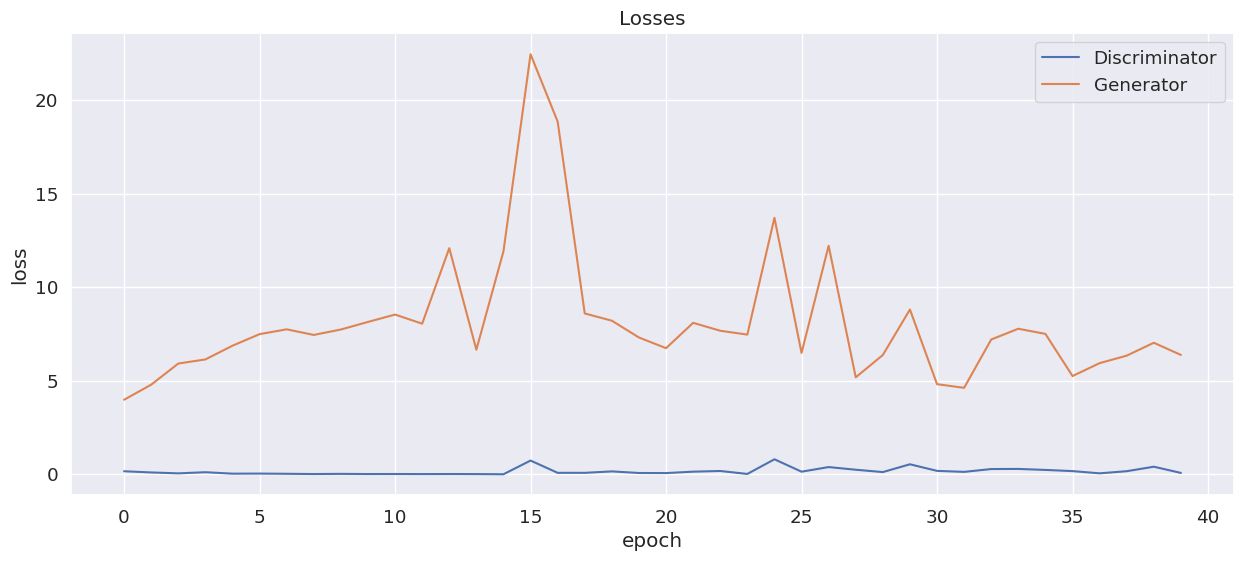

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

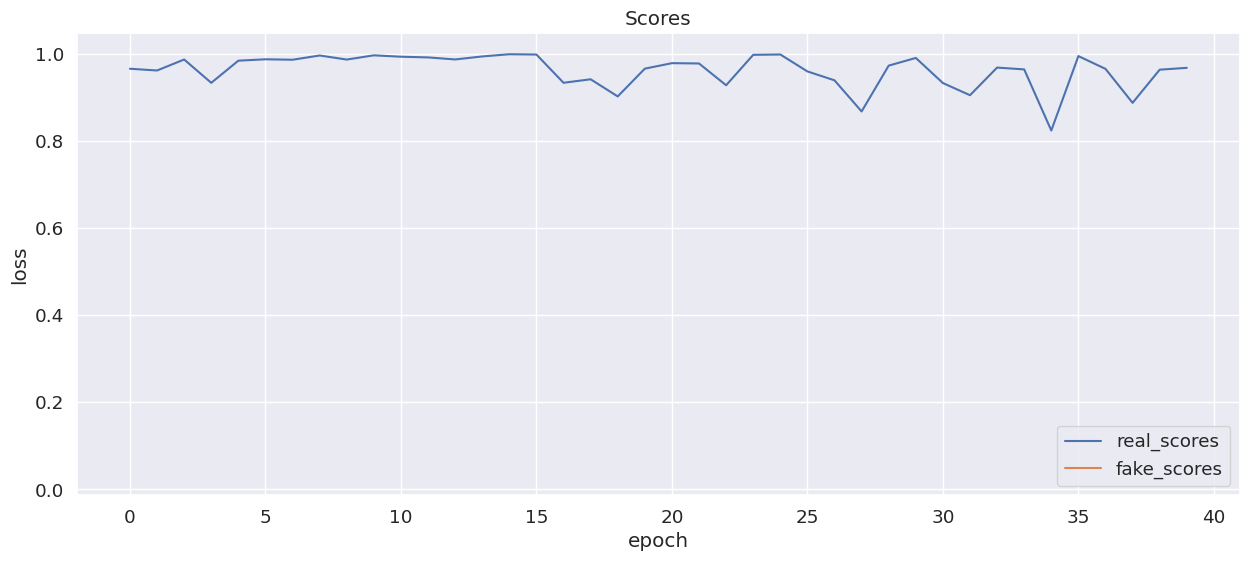

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['real_scores', 'fake_scores'])
plt.title("Scores");

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

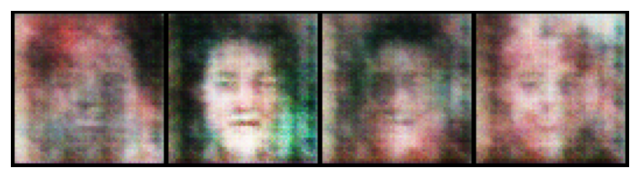

In [ ]:
show_images(fake_images.cpu())

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

cv = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

faces_data = get_data(image_size, batch_size)

generator = Generator()
generator.load_state_dict(torch.load('./gen_last_weight.pth', map_location=torch.device('cpu')))
generator.eval()

noise = torch.randn(len(faces_data), latent_size, 1, 1)

fake_data = generator(noise)
fake_labels = torch.zeros(fake_data.size(0), 1)

true_data = faces_data
true_labels = torch.ones(len(faces_data), 1)

all_labels = torch.cat((fake_labels, true_labels))

temp = []
for img, _ in tqdm(true_data):
    temp.append(img)
    
all_imgs = torch.cat((fake_data, torch.stack(temp)))

idx = np.arange(len(all_imgs))
np.random.shuffle(idx)
idx = idx[:3000]

  0%|          | 0/3143 [00:00<?, ?it/s]

In [ ]:
X = all_imgs.view(77242368, -1).detach().numpy()[idx]
y = all_labels.detach().numpy().ravel()[idx]

scores = cross_val_score(knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   14.7s finished


In [ ]:
print(f"Accuracy: {np.mean(scores)} {np.std(scores)}")

Accuracy: 0.5676666666666667 0.49540006279997806


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

<b>Вывод:</b> 

изображения получились неточными

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

X = all_imgs.view(77242368, -1).detach().numpy()
y = all_labels.detach().numpy().ravel()

tsne = TSNE(n_iter=250)
tsne_results = tsne.fit_transform(X)

fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='Latent Representation of faces' )
scatter = ax.scatter(
    x=X[:,0], 
    y=X[:,1], 
    c=y, 
    cmap=plt.cm.get_cmap('tab10'))
    
ax.legend(*scatter.legend_elements(), loc='upper left')
plt.show()

NameError: ignored

Colab не вывозит, ссылка на график (получил в ноутбуке kaggle)
https://drive.google.com/file/d/1O8xwUQxRQUJP6eGOLVB8CC6n2cUp57Ig/view?usp=share_link

Прокомментируйте получившийся результат: